## Setup

### Install required libraries

The libraries should already be installed in the terminal after running 
```
pip install -r requirements.txt
```
in the root directory, but this will be useful if the notebook is used in other environments.

If there is insufficient space, try purging the pip cache first.

In [147]:
# !pip cache purge

In [145]:
%%capture
# !pip uninstall torch torchvision torchaudio -y
!pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128
!pip install datasets==3.6.0
!pip install transformers==4.52.4
!pip install huggingface-hub==0.32.3
!pip install librosa==0.11.0
!pip install jiwer==3.1.0
!pip install evaluate==0.4.3
!pip install matplotlib==3.10.3
!pip install jiwer==3.1.0
!pip install requests==2.32.3
!pip install huggingface-hub==0.32.3
!pip install accelerate==1.7.0

### Import required libraries

In [220]:
from datasets import load_dataset, Dataset, Audio, load_from_disk
import random
import evaluate
import pandas as pd
import IPython.display as ipd
import re
import json
from transformers import (Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor, 
                            TrainingArguments, Trainer)
import numpy as np
import torch
import torchaudio
from torch.utils.data import DataLoader
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
import os
import matplotlib.pyplot as plt
from jiwer import wer, cer
import requests
from huggingface_hub import configure_http_backend
import urllib3

pd.set_option('display.max_colwidth', 100)

### Check Torch version

In [149]:
print("Torch Version: ", torch.version.cuda)
print("Is CUDA available: ", torch.cuda.is_available())
print("CUDA Device Name: ", torch.cuda.get_device_name(0))

Torch Version:  12.8
Is CUDA available:  True
CUDA Device Name:  NVIDIA GeForce RTX 5070 Ti


### Check GPU

The notebook is being hosted by a server.

In [150]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun  3 06:33:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 570.133.07     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070 Ti     On  |   00000000:02:00.0 Off |                  N/A |
|  0%   47C    P8             35W /  300W |    5381MiB /  16303MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Other configurations

In [151]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# [OPTIONAL] Use if there is SSL certificate verification issues
def backend_factory() -> requests.Session:
    session = requests.Session()
    session.verify = False
    return session


configure_http_backend(backend_factory=backend_factory)

## Data Preprocessing

Instead of using ```load_dataset``` from
```
from datasets import load_dataset
```
to load Common Voice data, we load the data directly from our project directory since it is already copied inside.

### Load labels

In [5]:
dataset_split = 'cv-valid-train'
cv_csv_file = f'../datasets/common_voice/{dataset_split}.csv'
train_df = pd.read_csv(cv_csv_file)
train_df.head(5)

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the old king had said,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dreams said the old woman,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those omens that brought you to me,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me be the first to welcome you to earth,3,2,NaN,NaN,NaN,NaN


### Clean labels' table

Make the text label uppercase because the model we are finetuning "facebook/wav2vec2-large-960h" is pretrained using Librispeech dataset, which are uppercased. Removed all the other unnecessary columns.

In [6]:
train_df['text'] = train_df['text'].str.upper()
cleaned_train_df = train_df.drop(['up_votes', 'down_votes', 'age', 'gender', 'accent', 'duration'], axis=1)
audio_files_directory = f'../datasets/common_voice/{dataset_split}'
cleaned_train_df["path"] = cleaned_train_df["filename"].apply(lambda x: os.path.join(audio_files_directory, x))
cleaned_train_df.head(5)

,filename,text,path
0,cv-valid-train/sample-000000.mp3,LEARN TO RECOGNIZE OMENS AND FOLLOW THEM THE OLD KING HAD SAID,../datasets/common_voice/cv-valid-train/cv-valid-train/sample-000000.mp3
1,cv-valid-train/sample-000001.mp3,EVERYTHING IN THE UNIVERSE EVOLVED HE SAID,../datasets/common_voice/cv-valid-train/cv-valid-train/sample-000001.mp3
2,cv-valid-train/sample-000002.mp3,YOU CAME SO THAT YOU COULD LEARN ABOUT YOUR DREAMS SAID THE OLD WOMAN,../datasets/common_voice/cv-valid-train/cv-valid-train/sample-000002.mp3
3,cv-valid-train/sample-000003.mp3,SO NOW I FEAR NOTHING BECAUSE IT WAS THOSE OMENS THAT BROUGHT YOU TO ME,../datasets/common_voice/cv-valid-train/cv-valid-train/sample-000003.mp3
4,cv-valid-train/sample-000004.mp3,IF YOU START YOUR EMAILS WITH GREETINGS LET ME BE THE FIRST TO WELCOME YOU TO EARTH,../datasets/common_voice/cv-valid-train/cv-valid-train/sample-000004.mp3


### Inspect text

Check if 'text' contains special characters that cannot be transcribed (eg. colon, comma, percentage, etc). We want to keep whitespaces because the model has to learn to predict when a full word is finished. If not, the output will be a sequence of characters with no spacing. Also, the apostrophes are kept because of pronounciation difference. The output shows that there is none, so the data is cleaned.

In [7]:
# This pattern keeps only rows with characters that are NOT uppercase letter, whitespace character, or a single quote '.
special_chars_pattern = r"[^A-Z\s']"

df_with_special_chars = cleaned_train_df[cleaned_train_df['text'].str.contains(special_chars_pattern, regex=True, na=False)]

print(df_with_special_chars.head(5))

Empty DataFrame
Columns: [filename, text, path]
Index: []


### Load and decode audio

In [8]:
cleaned_train_df = cleaned_train_df.rename(columns={"path": "audio"})
common_voice_train_original = Dataset.from_pandas(cleaned_train_df)
common_voice_train_temp = common_voice_train_original.cast_column("audio", Audio())

In [9]:
common_voice_train_temp[0]["audio"]

{'path': '../datasets/common_voice/cv-valid-train/cv-valid-train/sample-000000.mp3',
 'array': array([ 0.00000000e+00, -2.39675413e-13, -2.89491331e-14, ...,
         4.10622597e-04,  7.94679159e-04,  7.57522532e-04], shape=(196992,)),
 'sampling_rate': 48000}

The output of the cell above shows that the audio data is loaded with a sampling rate of 48 kHz, but 16 kHz is expected by the ```wav2vec2-large-960h``` model. Hence, we have to resample the audio data.

In [10]:
common_voice_train = common_voice_train_original.cast_column("audio", Audio(sampling_rate=16_000))

In [11]:
common_voice_train[0]["audio"]

{'path': '../datasets/common_voice/cv-valid-train/cv-valid-train/sample-000000.mp3',
 'array': array([-1.09139364e-11, -3.63797881e-12,  2.91038305e-11, ...,
         1.25038670e-04,  7.30113941e-04,  7.36901653e-04], shape=(65664,)),
 'sampling_rate': 16000}

In [12]:
common_voice_train

Dataset({
    features: ['filename', 'text', 'audio'],
    num_rows: 195776
})

### Understand the statistics of the audio sequences

The cell below calculate the 25th, 50th, and 75th percentile duration of the audio sequences. It plots the distribution as well. In order to reduce memory usage, we can remove data from the right tail.

25th percentile duration: 3.14 seconds
50th percentile duration: 4.13 seconds
75th percentile duration: 5.54 seconds




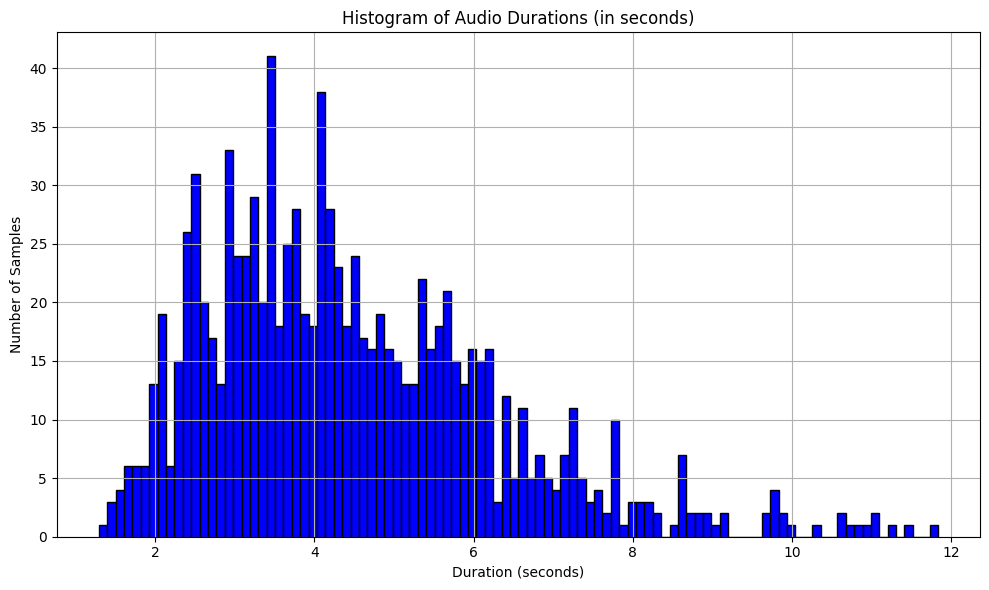

In [13]:
sample_dataset = common_voice_train[:1000]
audio_lengths = [len(sample["array"]) for sample in sample_dataset["audio"]]
sampling_rate = sample_dataset["audio"][0]["sampling_rate"]
audio_lengths_np = np.array(audio_lengths)
durations_seconds = audio_lengths_np / sampling_rate

for p in [25, 50, 75]:
    print(f"{p}th percentile duration: {np.percentile(durations_seconds, p):.2f} seconds")
print("\n")

plt.figure(figsize=(10, 6))
plt.hist(durations_seconds, bins=100, color='blue', edgecolor='black')
plt.title("Histogram of Audio Durations (in seconds)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.tight_layout()
plt.show()

### Filter out long audio sequences

Long audio sequences require a lot of memory. As the training will be done locally with limited computational resources, it is best to filter away these sequences.

In [14]:
def filter_short_audio_sequences(data, max_seconds=5):
    max_samples = 16000 * max_seconds
    return len(data["audio"]["array"]) <= max_samples

In [15]:
common_voice_train = common_voice_train.filter(filter_short_audio_sequences)

Filter: 100%|███████████████████████████████████████████| 195776/195776 [08:39<00:00, 376.66 examples/s]


In [16]:
common_voice_train

Dataset({
    features: ['filename', 'text', 'audio'],
    num_rows: 133647
})

### Check data

In [17]:
rand_int = random.randint(0, len(common_voice_train)-1)

print("Target text:", common_voice_train[rand_int]["text"])
print("Input array shape:", common_voice_train[rand_int]["audio"]["array"].shape)
print("Sampling rate:", common_voice_train[rand_int]["audio"]["sampling_rate"])
print("\n")
ipd.Audio(data=common_voice_train[rand_int]["audio"]["array"], autoplay=True, rate=16000)

Target text: I JUST WANT TO DREAM ABOUT MECCA
Input array shape: (55296,)
Sampling rate: 16000




## Tokenizer

### Building vocabulary

In Wav2Vec2 ASR models, the vocabulary is typically composed of characters or subword units, not whole words.

Since the "facebook/wav2vec2-large-960h" Wav2Vec2 model was pretrained using character-based vocabulary, we should stick to it.

We use a mapping function to build the vocabulary from the training data.

In [18]:
def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab]}

In [19]:
vocab_train = common_voice_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)

Map: 100%|███████████████████████████████████████████| 133647/133647 [00:00<00:00, 371772.37 examples/s]


The order of the alphabet is fixed to ensure that the input ids from the cached dataset (see later steps) can match with the vocabulary even with re-run.

In [20]:
vocab_list = list(set(vocab_train["vocab"][0]))
vocab_list.sort()
vocab_list

[' ',
 "'",
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [152]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}

# To avoid ambiguity for " " token class, we give it a more visible character "|".
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

vocab_dict

{"'": 1,
 'A': 2,
 'B': 3,
 'C': 4,
 'D': 5,
 'E': 6,
 'F': 7,
 'G': 8,
 'H': 9,
 'I': 10,
 'J': 11,
 'K': 12,
 'L': 13,
 'M': 14,
 'N': 15,
 'O': 16,
 'P': 17,
 'Q': 18,
 'R': 19,
 'S': 20,
 'T': 21,
 'U': 22,
 'V': 23,
 'W': 24,
 'X': 25,
 'Y': 26,
 'Z': 27,
 '|': 0}

We should check the pretrained processor to see the vocabulary it was trained on as well.

### Instantiate the pretrained processor

In [153]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

In [154]:
# Get the vocab dictionary from the tokenizer
vocab_dict = processor.tokenizer.get_vocab()
vocab_dict = dict(sorted(vocab_dict.items(), key=lambda item: item[1]))
vocab_dict

{'<pad>': 0,
 '<s>': 1,
 '</s>': 2,
 '<unk>': 3,
 '|': 4,
 'E': 5,
 'T': 6,
 'A': 7,
 'O': 8,
 'N': 9,
 'I': 10,
 'H': 11,
 'S': 12,
 'R': 13,
 'D': 14,
 'L': 15,
 'U': 16,
 'M': 17,
 'W': 18,
 'C': 19,
 'F': 20,
 'G': 21,
 'Y': 22,
 'P': 23,
 'B': 24,
 'V': 25,
 'K': 26,
 "'": 27,
 'X': 28,
 'J': 29,
 'Q': 30,
 'Z': 31}

Notice that the vocabulary is the same, except for the additional special tokens, eg. unknown and padding tokens. Since we are finetuning the pretrained model, we should stick to the vocabulary and the corresponding indexes the model is trained on. If we use our own generated vocabulary instead, this will cause the training loss to be higher at the start. This is due to mismatch between the embedding layer, which maps token IDs (from the vocabulary) to learned vectors.

### Save vocabulary

In [155]:
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

### Instantiate the tokenizer and the feature extractor

The processor contains the tokenizer, but there is a problem if we use the imported processor directly later. See [Issue “got multiple values for keyword argument” for Wav2Vec2 tokenizer](https://discuss.huggingface.co/t/issue-got-multiple-values-for-keyword-argument-for-wav2vec2-tokenizer/155931/2). Hence, we will need to instantiate the tokenizer and the feature extractor to build the processor.

In [156]:
tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="<unk>", pad_token="<pad>", bos_token = '<s>', eos_token = '</s>', word_delimiter_token="|")

In [157]:
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

### Instantiate the processor

In [158]:
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

## Data Preparation

### Split dataset

We have to split the 'cv-valid-train' dataset further down into 70-30 ratio, where 30% is kept for validation.

In [110]:
split = common_voice_train.train_test_split(test_size=0.3, seed=42)

common_voice_train_train = split['train']
common_voice_train_validation = split['test']

Inspect the ```training_dataset```

In [111]:
common_voice_train_train

Dataset({
    features: ['filename', 'text', 'audio'],
    num_rows: 93552
})

Inspect the ```validation_dataset```

In [112]:
common_voice_train_validation

Dataset({
    features: ['filename', 'text', 'audio'],
    num_rows: 40095
})

### Map data to be used by processor

Inside the ```prepare_dataset``` function, more complex feature extraction methods can be added inside.

In [31]:
def prepare_dataset(batch):
    audio = batch["audio"]

    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
        
    return batch

In [32]:
# training_dataset_cache_dir = "./caches/training"
# validation_dataset_cache_dir = "./caches/validation"

Apply the ```prepare_dataset``` to training and validation dataset. The mapped output will be saved under the *./caches* directory. This helps to save a lot of time and memory when the notebook is re-run again. This will take a bit of time and a lot of memory...

Uncomment the cells below to prepare the data again.

In [33]:
training_dataset = common_voice_train_train.map(prepare_dataset, remove_columns=common_voice_train_train.column_names, batched=False)

Map:   0%|                                                             | 0/93552 [00:00<?, ? examples/s]/workspace/htx-xdata-asr/venv/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Map: 100%|████████████████████████████████████████████████| 93552/93552 [03:56<00:00, 396.36 examples/s]


In [34]:
# os.makedirs(training_dataset_cache_dir, exist_ok=True)
# training_dataset.save_to_disk(training_dataset_cache_dir)

In [35]:
validation_dataset = common_voice_train_validation.map(prepare_dataset, remove_columns=common_voice_train_validation.column_names, batched=False)

Map: 100%|████████████████████████████████████████████████| 40095/40095 [01:45<00:00, 378.94 examples/s]


In [36]:
# os.makedirs(validation_dataset_cache_dir, exist_ok=True)
# validation_dataset.save_to_disk(validation_dataset_cache_dir)

### Load cached dataset

If ```training_dataset``` and ```validation_dataset``` are saved in the previous steps, we can skip the data mapping and go directly to load the dataset.

In [37]:
# training_dataset = load_from_disk(training_dataset_cache_dir)
# validation_dataset = load_from_disk(validation_dataset_cache_dir)

Sanity check

In [159]:
training_dataset

Dataset({
    features: ['input_values', 'labels'],
    num_rows: 93552
})

In [160]:
validation_dataset

Dataset({
    features: ['input_values', 'labels'],
    num_rows: 40095
})

## Training

### Instantiate a data collator

This is taken from [transformers/.../wav2vec2/run_asr.py](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

In [161]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [162]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

### Define evaluation metrics

The predominant metric in ASR is the word error rate (WER). Character error rate (CER) is often reported as a secondary metric to show finer error details. We will show these two metrics.

In [163]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer_score = wer(label_str, pred_str)
    cer_score = cer(label_str, pred_str)

    return {"wer": wer_score, "cer": cer_score}

### Load pretrained Wav2Vec2 model

The "facebook/wav2vec2-large-960h"'s Wav2Vec2 model is selected to be finetuned with the Common Voice dataset. This pretrained model will be compared with the finetuned model later.

Rationale for the hyperparameter settings:
- Keep to default hyperparameter values as the checkpoint "facebook/wav2vec2-large-960h" already includes carefully tuned values optimized for robust training on large English speech datasets.
- Since the training time is tight, we cannot afford to run extensive hyperparameter tuning experiments.
- Keeping these hyperparameters at their defaults reduces complexity, training time, and the risk of destabilizing the model during finetuning.

Link to the default configurations: https://huggingface.co/facebook/wav2vec2-large-960h/blob/main/config.json

In [164]:
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Inspect model

In [165]:
print(f"{'Parameter Name':<80} | {'Requires Grad'}")
print("-" * 100)

for name, param in model.named_parameters():
    print(f"{name:<80} | {param.requires_grad}")

Parameter Name                                                                   | Requires Grad
----------------------------------------------------------------------------------------------------
wav2vec2.masked_spec_embed                                                       | True
wav2vec2.feature_extractor.conv_layers.0.conv.weight                             | True
wav2vec2.feature_extractor.conv_layers.0.layer_norm.weight                       | True
wav2vec2.feature_extractor.conv_layers.0.layer_norm.bias                         | True
wav2vec2.feature_extractor.conv_layers.1.conv.weight                             | True
wav2vec2.feature_extractor.conv_layers.2.conv.weight                             | True
wav2vec2.feature_extractor.conv_layers.3.conv.weight                             | True
wav2vec2.feature_extractor.conv_layers.4.conv.weight                             | True
wav2vec2.feature_extractor.conv_layers.5.conv.weight                             | True
wav2vec2.f

### Freezing pretrained weights

In this finetuning experiment, we can freeze the convolutional feature extractor.

Rationale for Freezing the Feature Extractor:
- The feature extractor has been pretrained on large speech data to learn robust low-level audio representations, which are generally transferable across datasets.
- Freezing it reduces the number of trainable parameters, which lowers the computational cost and speeds up training. This is important since the training time is tight.

In [166]:
model.freeze_feature_extractor()

/workspace/htx-xdata-asr/venv/lib/python3.12/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:2084: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In addition to the convolutional feature extractor, we can also freeze early encoder layers.

Rationale for Freezing early Encoder Layers:
- The early layers contain learnt general audio representations and may not need re-training, especially for same language finetuning.
- Ensure later encoder layers are trained so that higher level features adapts better to our dataset.

In [167]:
# Freeze first 6 transformer layers
N = 6
for i in range(N):
    for param in model.wav2vec2.encoder.layers[i].parameters():
        param.requires_grad = False

Inspect the model again

In [168]:
print(f"{'Parameter Name':<80} | {'Requires Grad'}")
print("-" * 100)

for name, param in model.named_parameters():
    print(f"{name:<80} | {param.requires_grad}")

Parameter Name                                                                   | Requires Grad
----------------------------------------------------------------------------------------------------
wav2vec2.masked_spec_embed                                                       | True
wav2vec2.feature_extractor.conv_layers.0.conv.weight                             | False
wav2vec2.feature_extractor.conv_layers.0.layer_norm.weight                       | False
wav2vec2.feature_extractor.conv_layers.0.layer_norm.bias                         | False
wav2vec2.feature_extractor.conv_layers.1.conv.weight                             | False
wav2vec2.feature_extractor.conv_layers.2.conv.weight                             | False
wav2vec2.feature_extractor.conv_layers.3.conv.weight                             | False
wav2vec2.feature_extractor.conv_layers.4.conv.weight                             | False
wav2vec2.feature_extractor.conv_layers.5.conv.weight                             | False
wa

### Defining training arguments

Rationale for TrainingArguments settings:
- Briefly experimented with the batch size and found that a batch size of 16 uses more than half of the GPU RAM available but lower than the max limit. Hence, we keep it at 16.
- The *num_train_epochs* is kept to 5 first. The decision is made purely on logistics (eg. credit spending time, overnight training, etc). 5 epochs should also be good enough to show if the finetuning works.
- The *gradient_accumulation_steps* is set to 2, just to simulate higher batch size.
- Based on other references online, a learning rate between 1e-5 to 4e4 were used as the starting learning rate for finetuning on Wav2Vec2 models. We can start the experimentation by setting the learning rate to the middle range. It is chosen to be 1e-4 as we freezed extra encoder layers above. A slightly higher learning rate may help with bigger updates in the later stage of the encoders.
- *gradient_checkpointing=True* helps reduce memory usage during training.

In [189]:
training_args = TrainingArguments(
    output_dir='./checkpoints',
    logging_dir="./logs",
    group_by_length=True,
    # use_cpu=True,
    # per_device_train_batch_size=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    eval_strategy="steps",
    num_train_epochs=5,
    gradient_checkpointing=True,
    fp16=True,
    save_steps=500,
    eval_steps=500,
    logging_steps=500,
    learning_rate=1e-4,
    warmup_steps=500,
    max_grad_norm=1.0,
    save_total_limit=1,
    push_to_hub=False,
)

Test training with small subset of dataset first. Ensure that the training and validation results look ok before proceeding with the full dataset.

In [200]:
# small_training_dataset = training_dataset.select(range(1000))
# small_validation_dataset = validation_dataset.select(range(100))

In [201]:
# trainer = Trainer(
#     model=model,
#     data_collator=data_collator,
#     args=training_args,
#     compute_metrics=compute_metrics,
#     train_dataset=small_training_dataset,
#     eval_dataset=small_validation_dataset,
#     processing_class=processor,
# )

In [191]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=training_dataset,
    eval_dataset=validation_dataset,
    processing_class=processor,
)

Training starts here...

In [192]:
trainer.train()

/workspace/htx-xdata-asr/venv/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Step,Training Loss,Validation Loss,Wer,Cer
500,353.271700,145.843903,0.126987,0.049092
1000,268.986200,145.761429,0.104738,0.044101
1500,247.769400,120.227608,0.097185,0.039661
2000,227.707300,116.604027,0.091093,0.037372
2500,214.067800,101.417854,0.086905,0.035600
3000,208.016400,95.438957,0.077425,0.032199
3500,185.521100,92.321434,0.076824,0.031896
4000,177.826000,91.636467,0.072222,0.029916
4500,172.237600,92.544373,0.071264,0.029822
5000,165.090000,77.422501,0.065554,0.027261


/workspace/htx-xdata-asr/venv/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/workspace/htx-xdata-asr/venv/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/workspace/htx-xdata-asr/venv/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your l

TrainOutput(global_step=14620, training_loss=149.90172301160652, metrics={'train_runtime': 42547.1764, 'train_samples_per_second': 10.994, 'train_steps_per_second': 0.344, 'total_flos': 4.9155314333082845e+19, 'train_loss': 149.90172301160652, 'epoch': 5.0})

### Training and Validation Results

The cell below plots the losses and metrics against training steps. The following metrics are plotted:
- Training Loss and Validation loss vs Training Steps
- Validation WER vs Training Steps
- Validation CER vs Training Steps

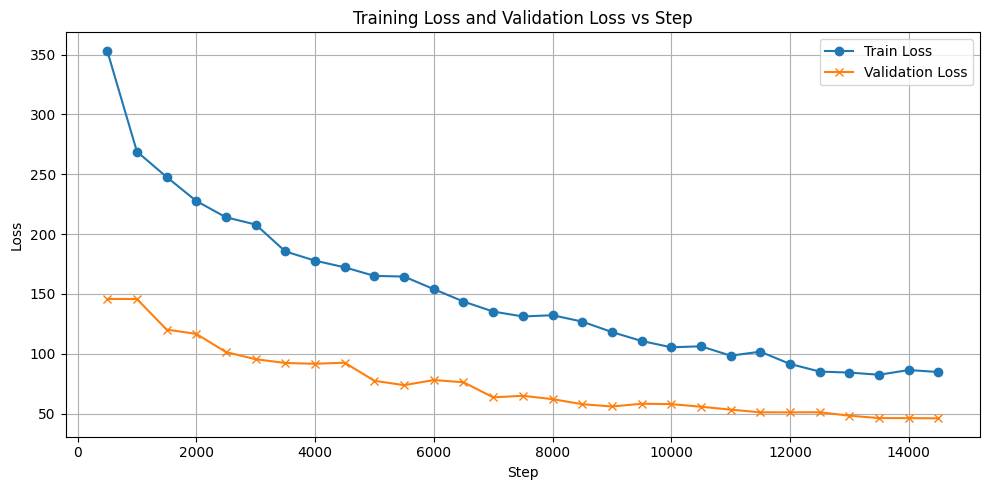

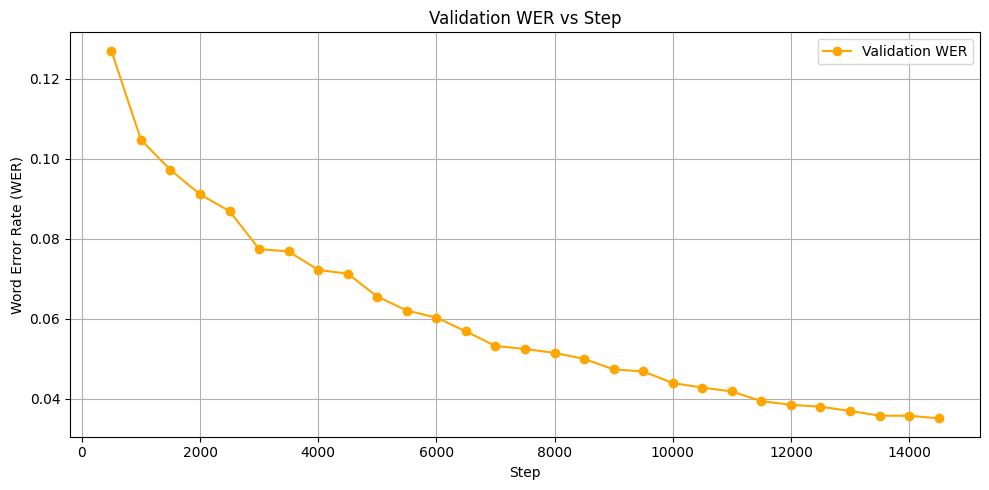

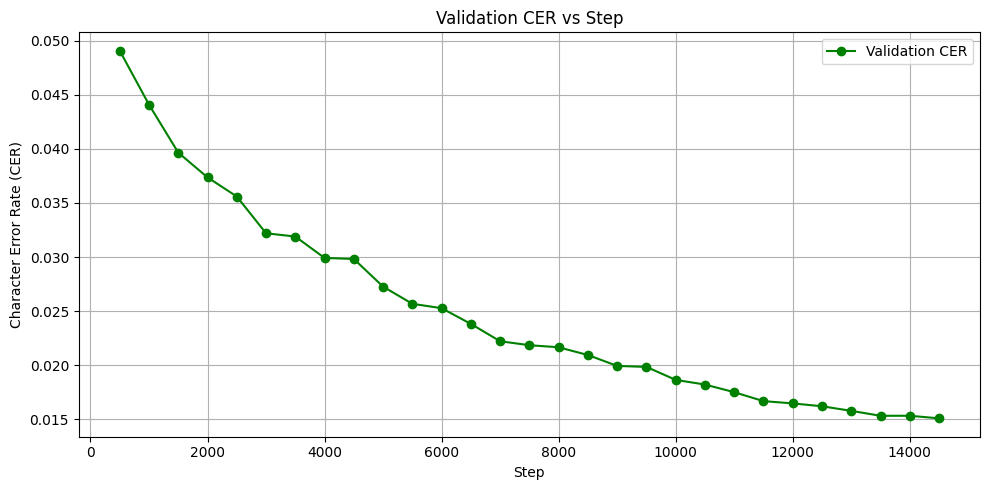

In [193]:
# Extract log history
log_history = trainer.state.log_history

# Prepare plot data
train_loss = [entry["loss"] for entry in log_history if "loss" in entry]
eval_loss = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
steps_train_loss = [entry["step"] for entry in log_history if "loss" in entry]
steps_eval_loss = [entry["step"] for entry in log_history if "eval_loss" in entry]

steps_wer = [entry["step"] for entry in log_history if "eval_wer" in entry]
eval_wer = [entry["eval_wer"] for entry in log_history if "eval_wer" in entry]

steps_cer = [entry["step"] for entry in log_history if "eval_cer" in entry]
eval_cer = [entry["eval_cer"] for entry in log_history if "eval_cer" in entry]

# Plot 1: Training Loss & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(steps_train_loss, train_loss, label="Train Loss", marker="o")
plt.plot(steps_eval_loss, eval_loss, label="Validation Loss", marker="x")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss and Validation Loss vs Step")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Validation WER
plt.figure(figsize=(10, 5))
plt.plot(steps_wer, eval_wer, label="Validation WER", color="orange", marker="o")
plt.xlabel("Step")
plt.ylabel("Word Error Rate (WER)")
plt.title("Validation WER vs Step")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Validation CER
plt.figure(figsize=(10, 5))
plt.plot(steps_cer, eval_cer, label="Validation CER", color="green", marker="o")
plt.xlabel("Step")
plt.ylabel("Character Error Rate (CER)")
plt.title("Validation CER vs Step")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation of Training and Validation Results

Training Loss and Validation Loss vs Training Steps:
- Both training loss and validation loss are steadily decreasing. This shows that the training is doing well.
- The reason why the training loss is higher than the validation loss may be due to having dropout active only in training, thereby introducing noise and increasing loss. The dropout should be inactive during evaluation.
- Both training loss and validation loss decline over time without sharp spikes or divergence. This suggests stable optimisation.
- Validation loss keeps decreasing along with training loss, so overfitting does not seem to be present.
- Loss reduction becomes more gradual after ~12,000 steps. The number of epochs can be increased to confirm this.

Validation WER vs Training Steps:
- The WER are dropping well, the model is clearly learning.
- The number of epochs can be increased to see if the metric continues to lower.

Validation CER vs Training Steps:
- The CER are dropping well, the model is clearly learning.
- The number of epochs can be increased to see if the metric continues to lower.

## Inference

We can visually check the output of the finetuned model.

Before that, we move the finetuned model out of the *./checkpoints* directory and into a new *./saved_models* directory. Then, we rename the model to "wav2vec2-large-960h-cv".

### Load finetuned model

In [202]:
finetuned_model = Wav2Vec2ForCTC.from_pretrained('./saved_models/wav2vec2-large-960h-cv')
finetuned_processor = Wav2Vec2Processor.from_pretrained('./saved_models/wav2vec2-large-960h-cv')

### Perform an inference

In [203]:
input_dict = finetuned_processor(validation_dataset[0]["input_values"], sampling_rate=16_000, return_tensors="pt", padding=True)
logits = finetuned_model(input_dict.input_values).logits
pred_ids = torch.argmax(logits, dim=-1)[0]

print("Prediction: ", finetuned_processor.decode(pred_ids))
print("Reference: ", common_voice_train_validation[0]["text"])

Prediction:  THEY MOUNTED THEIR HORSES
Reference:  THEY MOUNTED THEIR HORSES


The prediction is correct!

## Evaluation

In this section, we can evaluate the original model and the finetuned model using the test dataset.

### Load test dataset

For evaluation, we can use the test dataset. We will prepare the test dataset like how we prepare the training dataset.

In [204]:
dataset_split = 'cv-valid-test'
cv_csv_file = f'../datasets/common_voice/{dataset_split}.csv'
test_df = pd.read_csv(cv_csv_file)

test_df['text'] = test_df['text'].str.upper()
cleaned_test_df = test_df.drop(['up_votes', 'down_votes', 'age', 'gender', 'accent', 'duration'], axis=1)
audio_files_directory = f'../datasets/common_voice/{dataset_split}'
cleaned_test_df["path"] = cleaned_test_df["filename"].apply(lambda x: os.path.join(audio_files_directory, x))

cleaned_test_df = cleaned_test_df.rename(columns={"path": "audio"})
common_voice_test_original = Dataset.from_pandas(cleaned_test_df)
common_voice_test = common_voice_test_original.cast_column("audio", Audio(sampling_rate=16_000))

In [205]:
common_voice_test

Dataset({
    features: ['filename', 'text', 'audio'],
    num_rows: 3995
})

In [206]:
test_dataset = common_voice_test.map(prepare_dataset, remove_columns=common_voice_test.column_names, batched=False)

Map:   0%|                                                              | 0/3995 [00:00<?, ? examples/s]/workspace/htx-xdata-asr/venv/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Map: 100%|██████████████████████████████████████████████████| 3995/3995 [00:12<00:00, 323.22 examples/s]


### Evaluate and compare a set of models

In [207]:
models_to_eval = [
    "./saved_models/wav2vec2-large-960h-cv",
    "facebook/wav2vec2-large-960h",  # baseline model
]

for model_path in models_to_eval:
    finetuned_model = Wav2Vec2ForCTC.from_pretrained(model_path)
    finetuned_processor = Wav2Vec2Processor.from_pretrained(model_path)

    finetuned_trainer = Trainer(
        model=finetuned_model,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        processing_class=finetuned_processor,
        eval_dataset=test_dataset
    )

    result = finetuned_trainer.evaluate()
    print(f"Results for {model_path}: {result}")

/workspace/htx-xdata-asr/venv/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Results for ./saved_models/wav2vec2-large-960h-cv: {'eval_loss': 64.5927734375, 'eval_model_preparation_time': 0.0019, 'eval_wer': 0.09860718344477627, 'eval_cer': 0.0473034793980967, 'eval_runtime': 94.1848, 'eval_samples_per_second': 42.417, 'eval_steps_per_second': 5.309}


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/workspace/htx-xdata-asr/venv/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Results for facebook/wav2vec2-large-960h: {'eval_loss': 606.0673217773438, 'eval_model_preparation_time': 0.0018, 'eval_wer': 0.20569812617279382, 'eval_cer': 0.10760753257897267, 'eval_runtime': 94.1671, 'eval_samples_per_second': 42.425, 'eval_steps_per_second': 5.31}


The evaluation shows that the finetuned model is better than the original model. This is definitely the case because the training was successful, and we are comparing a baseline model with a finetuned model trained on the same dataset (Common Voice).

## Transcribe the Test Dataset

This section attempts Task 3c.

We use the same method used in Task 2d.

### Import functions used in Task 2

In [259]:
def list_files_in_directory(directory_path):
    try:
        files = [
            os.path.join(directory_path, f) for f in os.listdir(directory_path)
            if os.path.isfile(os.path.join(directory_path, f)) and not f.startswith("._")
        ]
        return files
    except Exception as e:
        logger.error(f"Error reading directory {directory_path}: {e}")
        return []

def transcribe_audio(waveform, sampling_rate, processor, model, REQUIRED_SAMPLING_RATE=16000):

    # Resample if needed
    if sampling_rate != REQUIRED_SAMPLING_RATE:
        resampler = torchaudio.transforms.Resample(
            orig_freq=sampling_rate, new_freq=REQUIRED_SAMPLING_RATE)
        waveform = resampler(waveform)

    # Convert to mono (not required using common-voice dataset)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # Inference
    input_values = processor(waveform.squeeze().numpy(),
                             return_tensors="pt",
                             padding=True,
                             sampling_rate=REQUIRED_SAMPLING_RATE).input_values

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_values = input_values.to(torch.float16).to(device)

    logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]

    return transcription

### Load test dataset to perform transcription

In [260]:
dataset_split = 'cv-valid-test'
files_directory = f'../datasets/common_voice/{dataset_split}/{dataset_split}'
files = list_files_in_directory(files_directory)
files[:5]

['../datasets/common_voice/cv-valid-test/cv-valid-test/sample-000551.mp3',
 '../datasets/common_voice/cv-valid-test/cv-valid-test/sample-001897.mp3',
 '../datasets/common_voice/cv-valid-test/cv-valid-test/sample-003058.mp3',
 '../datasets/common_voice/cv-valid-test/cv-valid-test/sample-002346.mp3',
 '../datasets/common_voice/cv-valid-test/cv-valid-test/sample-002420.mp3']

In [261]:
cv_csv_file = f'../datasets/common_voice/{dataset_split}.csv'
test_df = pd.read_csv(cv_csv_file)
test_df.head(5)

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-test/sample-000000.mp3,without the dataset the article is useless,1,0,NaN,NaN,NaN,NaN
1,cv-valid-test/sample-000001.mp3,i've got to go to him,1,0,twenties,male,NaN,NaN
2,cv-valid-test/sample-000002.mp3,and you know it,1,0,NaN,NaN,NaN,NaN
3,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of people sleeping in peace,4,0,twenties,male,us,NaN
4,cv-valid-test/sample-000004.mp3,hold your nose to keep the smell from disabling your motor functions,2,0,NaN,NaN,NaN,NaN


In [262]:
test_df['exact_filename'] = test_df['filename'].str.split('/').str[-1]
test_df['generated_text'] = ''
test_df.head(5)

,filename,text,up_votes,down_votes,age,gender,accent,duration,exact_filename,generated_text
0,cv-valid-test/sample-000000.mp3,without the dataset the article is useless,1,0,NaN,NaN,NaN,NaN,sample-000000.mp3,
1,cv-valid-test/sample-000001.mp3,i've got to go to him,1,0,twenties,male,NaN,NaN,sample-000001.mp3,
2,cv-valid-test/sample-000002.mp3,and you know it,1,0,NaN,NaN,NaN,NaN,sample-000002.mp3,
3,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of people sleeping in peace,4,0,twenties,male,us,NaN,sample-000003.mp3,
4,cv-valid-test/sample-000004.mp3,hold your nose to keep the smell from disabling your motor functions,2,0,NaN,NaN,NaN,NaN,sample-000004.mp3,


### Perform transcription

In [264]:
print(f"Performing transcription on {dataset_split}...\n")

for file_path in files:
    try:
        waveform, sampling_rate = torchaudio.load(file_path)
    except Exception as e:
        print("Error: ", e)
        break

    transcription = transcribe_audio(waveform, sampling_rate, finetuned_processor, finetuned_model)
        
    current_exact_filename = file_path.split('/')[-1]
    test_df.loc[test_df['exact_filename'] == current_exact_filename,
           'generated_text'] = transcription

print("Transcription done!")

Performing transcription on cv-valid-test...

Transcription done!


In [265]:
test_df['text'] = test_df['text'].str.upper()
test_df.head(5)

,filename,text,up_votes,down_votes,age,gender,accent,duration,exact_filename,generated_text
0,cv-valid-test/sample-000000.mp3,WITHOUT THE DATASET THE ARTICLE IS USELESS,1,0,NaN,NaN,NaN,NaN,sample-000000.mp3,WITHOUT THE DATASET THE ARTICLEAS USELESS
1,cv-valid-test/sample-000001.mp3,I'VE GOT TO GO TO HIM,1,0,twenties,male,NaN,NaN,sample-000001.mp3,F CATEGIL TO HIM
2,cv-valid-test/sample-000002.mp3,AND YOU KNOW IT,1,0,NaN,NaN,NaN,NaN,sample-000002.mp3,AND YOU KNOW IT
3,cv-valid-test/sample-000003.mp3,DOWN BELOW IN THE DARKNESS WERE HUNDREDS OF PEOPLE SLEEPING IN PEACE,4,0,twenties,male,us,NaN,sample-000003.mp3,DOWN BELOW IN THE DARKNESS WERE HUNDREDS OF PEOPLE SLEEPING IN PEACE
4,cv-valid-test/sample-000004.mp3,HOLD YOUR NOSE TO KEEP THE SMELL FROM DISABLING YOUR MOTOR FUNCTIONS,2,0,NaN,NaN,NaN,NaN,sample-000004.mp3,HOLD YOUR NOSE TO KEEP THE SMELL FROM DISABLING YOUR MOTIVE FUNCTIONS


### Get transcription performance

We compute the WER and CER for every row of data.

In [266]:
def compute_scores(row):
    label = row['text']
    pred = row['generated_text']
    return pd.Series({
        'wer_score': wer(label, pred),
        'cer_score': cer(label, pred)
    })

In [269]:
test_df[['wer_score', 'cer_score']] = test_df.apply(compute_scores, axis=1)

overall_wer = test_df['wer_score'].mean()
overall_cer = test_df['cer_score'].mean()

print(f"Overall WER: {overall_wer:.4f}")
print(f"Overall CER: {overall_cer:.4f}")

Overall WER: 0.1134
Overall CER: 0.0486


### Save the updated CSV

In [270]:
test_df = test_df.drop('exact_filename', axis=1)
output_csv = f'./{dataset_split}-with-generated-text.csv'
test_df.to_csv(output_csv, index=False)

print(f"Transcriptions saved to {output_csv}")

Transcriptions saved to ./cv-valid-test-with-generated-text.csv
